# Clustering Method

Clustering is a machine learning technique that are widely used for unsupervised learning. Unlike prediction methods such as linear regression, clustering is a descriptive method that we can used to discover the relationships among data. 

In this notebook, I implemented hierachical clustering, k-means clustering, DBSCAN


## 1. Connectivity-based clustering

### 1.1 hierachical clustering 

Hierachical clusters are built using dendrograms, where the heights of each nodes indicates the similarity/distances between clusters (items). 

In this example we used **single-link (nearest neighbor), bottom-up approach (agglomerative)** to model a hierachical clustering. The cluster is constructed starting from each item, we want to find the best pair to merge into new clusters. This merging step is repeated until all the clusters are fused into one. 

An alternative of the bottom-up is the **top-down (divisive) approach** that we try to find the best division at each level starting from one cluster of all the data. 

We have the following dataset: 

<span style="color:blue">{0, 4, 5, 20, 25, 39, 43, 44}</span>


In [53]:
# import data
import numpy as np
import pandas as pd
import timeit

data = [0, 4, 5, 20, 25, 39, 43, 44]
ctys = [0, 4, 5, 20, 25, 39, 43, 44]

df = pd.DataFrame(data, index=ctys)
df

,0
0,0
4,4
5,5
20,20
25,25
39,39
43,43
44,44


### Steps

1. Compute the Euclidean distance between each point<br>
2. Build clusters with single-link<br>

Single-link means that at each level, the distance between two clusters is determined by the distance of the two closet (nearest neighbors) in the different clusters. 

***
From the distance matrix below, we have the following pairs at each level: 

__Level 1: 3+2 clusters (bottom)__

* closet distance{4, 5} = 1
* closet distance{43, 44} = 1
* closet distance{20, 25} = 5

__Level 2: 2+1 clusters__

* closet distance {4, 5} & {0} = 4
* closet distance {43, 44} & {39} = 4

__Level 3: 2 clusters__ 

* closet distance {20, 25} & {39, 43, 44} = 14


__Level 4: 1 cluster (top)__

* closet distance {20, 25, 39, 43, 44} & {4, 5, 0} = 15



In [9]:
# euclidean distance
from scipy.spatial import distance_matrix

pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)

,0,4,5,20,25,39,43,44
0,0.0,4.0,5.0,20.0,25.0,39.0,43.0,44.0
4,4.0,0.0,1.0,16.0,21.0,35.0,39.0,40.0
5,5.0,1.0,0.0,15.0,20.0,34.0,38.0,39.0
20,20.0,16.0,15.0,0.0,5.0,19.0,23.0,24.0
25,25.0,21.0,20.0,5.0,0.0,14.0,18.0,19.0
39,39.0,35.0,34.0,19.0,14.0,0.0,4.0,5.0
43,43.0,39.0,38.0,23.0,18.0,4.0,0.0,1.0
44,44.0,40.0,39.0,24.0,19.0,5.0,1.0,0.0


In [20]:
# euclidean distance
from sklearn.metrics.pairwise import euclidean_distances

pd.DataFrame(euclidean_distances(df.values), index=df.index, columns=df.index)

,0,4,5,20,25,39,43,44
0,0.0,4.0,5.0,20.0,25.0,39.0,43.0,44.0
4,4.0,0.0,1.0,16.0,21.0,35.0,39.0,40.0
5,5.0,1.0,0.0,15.0,20.0,34.0,38.0,39.0
20,20.0,16.0,15.0,0.0,5.0,19.0,23.0,24.0
25,25.0,21.0,20.0,5.0,0.0,14.0,18.0,19.0
39,39.0,35.0,34.0,19.0,14.0,0.0,4.0,5.0
43,43.0,39.0,38.0,23.0,18.0,4.0,0.0,1.0
44,44.0,40.0,39.0,24.0,19.0,5.0,1.0,0.0


In [31]:
# hierachical clustering with sklearn
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
# default distance: euclidean

from sklearn.cluster import AgglomerativeClustering

# reshape np.array into 1 col & unknow rows
X = np.array([0, 4, 5, 20, 25, 39, 43, 44]).reshape(-1, 1)

clustering = AgglomerativeClustering(linkage='single').fit(X)

print('Labels:')
print (clustering.labels_)


Labels:
[1 1 1 0 0 0 0 0]


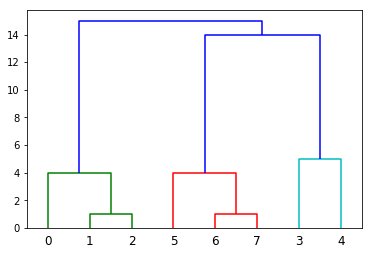

In [46]:
# plotting by scipy.cluster
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

X = np.array([0, 4, 5, 20, 25, 39, 43, 44]).reshape(-1, 1)
Z = linkage(X, method='single', metric='euclidean')

dn = dendrogram(Z, get_leaves=True)
plt.show()

## 2. Partitioning clustering

### 2.1 k-means

k-means clustering partition data into k pre-defined groups by minimizing the objective function at each iteration. 

Firstly, we pick k data points randomly as centers, and classify all the rest data to their closet centers. Now that we have k clusters after the 1st iteration, we calculate the mean of each clusters as new centers. Then we classify data points again based on the new centers. This iteration continue until centers == new centers.

This example is implemented using segment.csv, the dataset is based on a set of images taken in color around the UMASS campus. The goal is to find clusters in the data which define different types of objects (buildings, trees, sky etc). 


In [49]:
# setup and import data
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

df = pd.read_csv('Desktop/Code/cisc6930_dm/data/segment.csv', sep = ',')
df.shape
# df.head()
# df_col_names = df.columns

(2310, 21)

In [50]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

df_std = df.iloc[:,1:20]
y = df[['class']]

# apply z-score normalization for preprocessing 
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(df_std)
X = pd.DataFrame(x_scaled, columns = df_std.columns)
X.head()
# X.shape?

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,region-centroid-col,region-centroid-row,region-pixel-count,short-line-density-5,short-line-density-2,vedge-mean,vegde-sd,hedge-mean,hedge-sd,intensity-mean,rawred-mean,rawblue-mean,rawgreen-mean,exred-mean,exblue-mean,exgreen-mean,value-mean,saturation-mean,hue-mean
0,1.276189,0.949736,0.0,2.410668,-0.194552,-0.393061,-0.115120,-0.363952,-0.130944,0.591541,0.560193,0.713137,0.469693,-0.765452,1.296479,-1.429044,0.701072,-0.472693,-0.438610
1,-0.163336,0.114538,0.0,-0.357047,-0.194552,-0.598950,-0.121739,-0.579445,-0.133992,-0.947458,-0.936970,-0.956668,-0.936122,0.865568,-0.838573,0.552826,-0.992297,2.510764,-0.492138
2,1.056833,-1.434058,0.0,-0.357047,-0.194552,-0.351882,-0.110113,-0.363952,-0.122759,2.252805,2.257194,2.196563,2.291130,-1.792025,1.472504,-0.697872,2.205432,-0.996872,-0.606487
3,-1.273827,0.862737,0.0,-0.357047,-0.194552,-0.063639,-0.087601,1.821759,-0.025412,0.171373,0.192248,0.199941,0.115183,0.050061,0.331163,-0.611285,0.180634,-0.700863,-0.411626
4,-0.876244,1.280336,0.0,-0.357047,-0.194552,-0.166585,-0.093539,0.051641,-0.107455,0.328573,0.325468,0.399093,0.243541,-0.295331,0.740002,-0.957632,0.382596,-0.543100,-0.426778


In [ ]:
# dataframe = pd.concat([X, y], axis = 1)
# dataframe.head()

In [57]:
# k-means function from scratch 
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances_argmin_min

def k_means(X, k):
    
    # 1. intialization 
    centroid_list = [775, 1020, 200, 127, 329, 1626, 1515, 651, 658, 328, 1160, 108, 422, 88, 105, 261, 212, 1941, 1724, 704, 1469, 635, 867, 1187, 445, 222, 1283, 1288, 1766, 1168, 566, 1812, 214, 53, 423, 50, 705, 1284, 1356, 996, 1084, 1956, 254, 711, 1997, 1378, 827, 1875, 424, 1790, 633, 208, 1670, 1517, 1902, 1476, 1716, 1709, 264, 1, 371, 758, 332, 542, 672, 483, 65, 92, 400, 1079, 1281, 145, 1410, 664, 155, 166, 1900, 1134, 1462, 954, 1818, 1679, 832, 1627, 1760, 1330, 913, 234, 1635, 1078, 640, 833, 392, 1425, 610, 1353, 1772, 908, 1964, 1260, 784, 520, 1363, 544, 426, 1146, 987, 612, 1685, 1121, 1740, 287, 1383, 1923, 1665, 19, 1239, 251, 309, 245, 384, 1306, 786, 1814, 7, 1203, 1068, 1493, 859, 233, 1846, 1119, 469, 1869, 609, 385, 1182, 1949, 1622, 719, 643, 1692, 1389, 120, 1034, 805, 266, 339, 826, 530, 1173, 802, 1495, 504, 1241, 427, 1555, 1597, 692, 178, 774, 1623, 1641, 661, 1242, 1757, 553, 1377, 1419, 306, 1838, 211, 356, 541, 1455, 741, 583, 1464, 209, 1615, 475, 1903, 555, 1046, 379, 1938, 417, 1747, 342, 1148, 1697, 1785, 298, 1485, 945, 1097, 207, 857, 1758, 1390, 172, 587, 455, 1690, 1277, 345, 1166, 1367, 1858, 1427, 1434, 953, 1992, 1140, 137, 64, 1448, 991, 1312, 1628, 167, 1042, 1887, 1825, 249, 240, 524, 1098, 311, 337, 220, 1913, 727, 1659, 1321, 130, 1904, 561, 1270, 1250, 613, 152, 1440, 473, 1834, 1387, 1656, 1028, 1106, 829, 1591, 1699, 1674, 947, 77, 468, 997, 611, 1776, 123, 979, 1471, 1300, 1007, 1443, 164, 1881, 1935, 280, 442, 1588, 1033, 79, 1686, 854, 257, 1460, 1380, 495, 1701, 1611, 804, 1609, 975, 1181, 582, 816, 1770, 663, 737, 1810, 523, 1243, 944, 1959, 78, 675, 135, 1381, 1472]
    sse_list = []
    
    # ran k-means 25 times with different starting positions
    for c in range(25):  
        i = centroid_list[(c*k):((c+1)*k)] # subset if cenriod lists
        centers = X.loc[i]
        
        iteration = 1
        
        # 2. EM algorithm for k-means 
        while True:
            
#             print("\nIteration #", iteration)
            iteration = iteration + 1     
            
            # 2a. Assign labels based on closest center
            labels = pairwise_distances_argmin(X, centers) # return the center/row of y that is closet to X
        
            # 2b. for each label, get the mean of this cluster as new centers
            # mean(0) take the mean of each column
            new_centers = np.array([X[labels == i].mean(0) for i in range(k)])
        
            # 2c. Check for convergence
            if np.all(centers == new_centers) or iteration>50:
                break
            centers = new_centers
            
        # 3. Calcuate SSE  for each of the 25 runs 
        sse = sum(pairwise_distances_argmin_min(X, centers)[1]**2)
        sse_list.append(sse) # a list of the SSE for each 25 runs of different starting points

        # 4. compute the mean SSE 
        msse = np.mean(sse_list)
        std_sse = np.std(sse_list)
        
    return sse_list, msse, std_sse



### Problem (a)

For each k = 1,2,...,12 compute the mean SSE, which we denote μk and the sample standard deviation of SSE, which we denote σk, over all 25 clustering runs for that value of k. 

Generate a line plot of the mean SSE (μk) as a function of k. Include error bars that indicate the 95% confidence interval: (μk − 2σk to μk +2σk).

In [52]:
sse_k = {}
std_k = []

# A loop for k = 1...12
for i in range(2, 13):
    sse_list, msse, std_sse = k_means(X, k = i)
    sse_k[i] = msse
    std_k.append(float(std_sse))

ksse = pd.DataFrame.from_dict(sse_k, orient='index')
ksse['std'] = pd.Series(std_k).values
ksse.columns = ['msse', 'std']
ksse

,msse,std
2,7106.497780,255.976837
3,6317.294706,263.974050
4,5736.049454,377.272991
5,5373.420011,283.665170
6,5095.033741,177.738232
7,4873.331962,80.219490
8,4675.163746,100.939727
9,4544.732848,78.424063
10,4376.710832,86.887824
11,4243.947798,103.787472


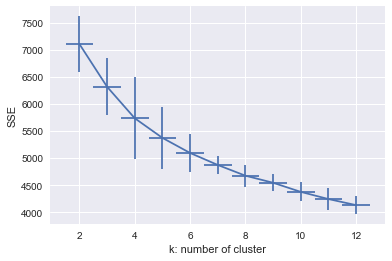

In [58]:
plt.figure()
# plt.plot(list(sse_k.keys()), list(sse_k.values()))
plt.errorbar(list(sse_k.keys()), list(sse_k.values()), xerr=0.5, yerr=2*np.array(std_k))
plt.xlabel("k: number of cluster")
plt.ylabel("SSE")
plt.show()

### Problem (b)

Produce a table containing the 4 columns: k, μk, μk − 2σk and μk + 2σk for each of the values of k = 1,2,...,12.

In [59]:
ksse['mu-2std'] = ksse['msse']-2*ksse['std']
ksse['mu+2std'] = ksse['msse']+2*ksse['std']
ksse.reset_index(level=0, inplace=True)

table = ksse.drop('std', 1)
table.columns = ['k', 'msse', 'mu-2std', 'mu+2std']

table

,k,msse,mu-2std,mu+2std
0,2,7106.497780,6594.544107,7618.451454
1,3,6317.294706,5789.346605,6845.242807
2,4,5736.049454,4981.503472,6490.595437
3,5,5373.420011,4806.089671,5940.750350
4,6,5095.033741,4739.557276,5450.510206
5,7,4873.331962,4712.892982,5033.770943
6,8,4675.163746,4473.284293,4877.043200
7,9,4544.732848,4387.884723,4701.580973
8,10,4376.710832,4202.935184,4550.486481
9,11,4243.947798,4036.372853,4451.522743


In [236]:
# a predefined Random Starting Positions
# 300 centroids for 25 runs of k=range(1,12) clustering 
centroid_list = [775, 1020, 200, 127, 329, 1626, 1515, 651, 658, 328, 1160, 108, 422, 88, 105, 261, 212, 1941, 1724, 704, 1469, 635, 867, 1187, 445, 222, 1283, 1288, 1766, 1168, 566, 1812, 214, 53, 423, 50, 705, 1284, 1356, 996, 1084, 1956, 254, 711, 1997, 1378, 827, 1875, 424, 1790, 633, 208, 1670, 1517, 1902, 1476, 1716, 1709, 264, 1, 371, 758, 332, 542, 672, 483, 65, 92, 400, 1079, 1281, 145, 1410, 664, 155, 166, 1900, 1134, 1462, 954, 1818, 1679, 832, 1627, 1760, 1330, 913, 234, 1635, 1078, 640, 833, 392, 1425, 610, 1353, 1772, 908, 1964, 1260, 784, 520, 1363, 544, 426, 1146, 987, 612, 1685, 1121, 1740, 287, 1383, 1923, 1665, 19, 1239, 251, 309, 245, 384, 1306, 786, 1814, 7, 1203, 1068, 1493, 859, 233, 1846, 1119, 469, 1869, 609, 385, 1182, 1949, 1622, 719, 643, 1692, 1389, 120, 1034, 805, 266, 339, 826, 530, 1173, 802, 1495, 504, 1241, 427, 1555, 1597, 692, 178, 774, 1623, 1641, 661, 1242, 1757, 553, 1377, 1419, 306, 1838, 211, 356, 541, 1455, 741, 583, 1464, 209, 1615, 475, 1903, 555, 1046, 379, 1938, 417, 1747, 342, 1148, 1697, 1785, 298, 1485, 945, 1097, 207, 857, 1758, 1390, 172, 587, 455, 1690, 1277, 345, 1166, 1367, 1858, 1427, 1434, 953, 1992, 1140, 137, 64, 1448, 991, 1312, 1628, 167, 1042, 1887, 1825, 249, 240, 524, 1098, 311, 337, 220, 1913, 727, 1659, 1321, 130, 1904, 561, 1270, 1250, 613, 152, 1440, 473, 1834, 1387, 1656, 1028, 1106, 829, 1591, 1699, 1674, 947, 77, 468, 997, 611, 1776, 123, 979, 1471, 1300, 1007, 1443, 164, 1881, 1935, 280, 442, 1588, 1033, 79, 1686, 854, 257, 1460, 1380, 495, 1701, 1611, 804, 1609, 975, 1181, 582, 816, 1770, 663, 737, 1810, 523, 1243, 944, 1959, 78, 675, 135, 1381, 1472]
centroid_5 = [775, 1020, 200, 127, 329]

data_5 = np.array(X.loc[centroid_5])
data = X
sse = {}

kmeans = KMeans(n_clusters=5, max_iter=50, init=data_5).fit(X)
y_kmeans = kmeans.predict(X)
data["clusters"] = kmeans.labels_
#print(data["clusters"])
sse = kmeans.inertia_ # inertia: sum of distances of samples to their closest cluster center
sse

/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


15844.351275614514

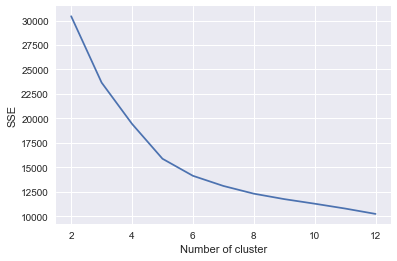

{2: 30441.089111211117,
 3: 23662.83716608674,
 4: 19442.096776879258,
 5: 15881.569797210528,
 6: 14138.43744808351,
 7: 13102.895656198481,
 8: 12312.91207615028,
 9: 11758.051433430346,
 10: 11288.85218990104,
 11: 10794.372712611259,
 12: 10244.673806399449}

In [237]:
# sklearn: k-means
from sklearn.cluster import KMeans
data = X
sse = {} # initiate a empty set 

for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, max_iter=50).fit(X)
    y_kmeans = kmeans.predict(X)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # inertia: sum of distances of samples to their closest cluster center
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()
sse

In [ ]:
scaler = StandardScaler()
cluster = KMeans(random_state=1337)
pipe = make_pipeline(scaler, cluster)

centroids = []
inertias = []
min_ks = []
inertia_temp = 9999.0

for k in range(2, 13):
    pipe.set_params(cluster__n_clusters=k)
    pipe.fit(X_pca)
    centroid = pipe.named_steps['cluster'].cluster_centers_
    inertia = pipe.named_steps['cluster'].inertia_        
    centroids.append(centroid)
    inertias.append(inertia)

    if inertia < inertia_temp:
        min_ks.append(k)

### Problem (c) 

As k increases and approaches the total number of examples N, what value does the SSE approach? What problems does this cause in terms of using SSE to choose an optimal k?

### Answer:

As k increases and approaches N, SSE would approach 0. In the extreme case, when the number of clusters k equals the total number of examples N, the SSE will be 0, since there will be no differences/distance between the centroid of the clusters to the data point. 

This leads to the problem that if we choose k based on minimizing SSE, will be eventually get a very large k value that may not best represent the clusters within the data. 

### Problem (d) 

Can you suggest another measure of cluster compactness and separation that might be more useful than SSE?

### Answer: 

1) Another measure that might be more useful than SSE is sihouette analysis. It measures how close each point in one clusters is to points in the neighboring clusters with a range of [-1, 1]

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. 

A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.


2) We can also use gap statistics.

Gap statistics aims to standardize the comparision of the log of the normalized sum of squares with a null reference distribution of the data. 

Optimal K is obtained at when the log of the normalized SSM falls the farthest below the reference curve. 

In [328]:
from sklearn.metrics import pairwise_distances_argmin_min

# k = 5 
# c = 
centroid_list = [775, 1020, 200, 127, 329, 1626, 1515, 651, 658, 328, 1160, 108, 422, 88, 105, 261, 212, 1941, 1724, 704, 1469, 635, 867, 1187, 445, 222, 1283, 1288, 1766, 1168, 566, 1812, 214, 53, 423, 50, 705, 1284, 1356, 996, 1084, 1956, 254, 711, 1997, 1378, 827, 1875, 424, 1790, 633, 208, 1670, 1517, 1902, 1476, 1716, 1709, 264, 1, 371, 758, 332, 542, 672, 483, 65, 92, 400, 1079, 1281, 145, 1410, 664, 155, 166, 1900, 1134, 1462, 954, 1818, 1679, 832, 1627, 1760, 1330, 913, 234, 1635, 1078, 640, 833, 392, 1425, 610, 1353, 1772, 908, 1964, 1260, 784, 520, 1363, 544, 426, 1146, 987, 612, 1685, 1121, 1740, 287, 1383, 1923, 1665, 19, 1239, 251, 309, 245, 384, 1306, 786, 1814, 7, 1203, 1068, 1493, 859, 233, 1846, 1119, 469, 1869, 609, 385, 1182, 1949, 1622, 719, 643, 1692, 1389, 120, 1034, 805, 266, 339, 826, 530, 1173, 802, 1495, 504, 1241, 427, 1555, 1597, 692, 178, 774, 1623, 1641, 661, 1242, 1757, 553, 1377, 1419, 306, 1838, 211, 356, 541, 1455, 741, 583, 1464, 209, 1615, 475, 1903, 555, 1046, 379, 1938, 417, 1747, 342, 1148, 1697, 1785, 298, 1485, 945, 1097, 207, 857, 1758, 1390, 172, 587, 455, 1690, 1277, 345, 1166, 1367, 1858, 1427, 1434, 953, 1992, 1140, 137, 64, 1448, 991, 1312, 1628, 167, 1042, 1887, 1825, 249, 240, 524, 1098, 311, 337, 220, 1913, 727, 1659, 1321, 130, 1904, 561, 1270, 1250, 613, 152, 1440, 473, 1834, 1387, 1656, 1028, 1106, 829, 1591, 1699, 1674, 947, 77, 468, 997, 611, 1776, 123, 979, 1471, 1300, 1007, 1443, 164, 1881, 1935, 280, 442, 1588, 1033, 79, 1686, 854, 257, 1460, 1380, 495, 1701, 1611, 804, 1609, 975, 1181, 582, 816, 1770, 663, 737, 1810, 523, 1243, 944, 1959, 78, 675, 135, 1381, 1472]
i = centroid_list[(24*12):((24+1)*12)]
i
# centers = X.loc[i]

# labels = pairwise_distances_argmin(X, centers)
# new_centers = np.array([X[labels == i].mean(0) for i in range(5)])

# sse = sum(pairwise_distances_argmin_min(X, new_centers)[1]**2)
# sse

[663, 737, 1810, 523, 1243, 944, 1959, 78, 675, 135, 1381, 1472]

In [314]:
from sklearn.metrics import pairwise_distances_argmin

def clusters(X):
    # 1. Randomly choose clusters
    centroid_list = [775, 1020, 200, 127, 329, 1626, 1515, 651, 658, 328, 1160, 108, 422, 88, 105, 261, 212, 1941, 1724, 704, 1469, 635, 867, 1187, 445, 222, 1283, 1288, 1766, 1168, 566, 1812, 214, 53, 423, 50, 705, 1284, 1356, 996, 1084, 1956, 254, 711, 1997, 1378, 827, 1875, 424, 1790, 633, 208, 1670, 1517, 1902, 1476, 1716, 1709, 264, 1, 371, 758, 332, 542, 672, 483, 65, 92, 400, 1079, 1281, 145, 1410, 664, 155, 166, 1900, 1134, 1462, 954, 1818, 1679, 832, 1627, 1760, 1330, 913, 234, 1635, 1078, 640, 833, 392, 1425, 610, 1353, 1772, 908, 1964, 1260, 784, 520, 1363, 544, 426, 1146, 987, 612, 1685, 1121, 1740, 287, 1383, 1923, 1665, 19, 1239, 251, 309, 245, 384, 1306, 786, 1814, 7, 1203, 1068, 1493, 859, 233, 1846, 1119, 469, 1869, 609, 385, 1182, 1949, 1622, 719, 643, 1692, 1389, 120, 1034, 805, 266, 339, 826, 530, 1173, 802, 1495, 504, 1241, 427, 1555, 1597, 692, 178, 774, 1623, 1641, 661, 1242, 1757, 553, 1377, 1419, 306, 1838, 211, 356, 541, 1455, 741, 583, 1464, 209, 1615, 475, 1903, 555, 1046, 379, 1938, 417, 1747, 342, 1148, 1697, 1785, 298, 1485, 945, 1097, 207, 857, 1758, 1390, 172, 587, 455, 1690, 1277, 345, 1166, 1367, 1858, 1427, 1434, 953, 1992, 1140, 137, 64, 1448, 991, 1312, 1628, 167, 1042, 1887, 1825, 249, 240, 524, 1098, 311, 337, 220, 1913, 727, 1659, 1321, 130, 1904, 561, 1270, 1250, 613, 152, 1440, 473, 1834, 1387, 1656, 1028, 1106, 829, 1591, 1699, 1674, 947, 77, 468, 997, 611, 1776, 123, 979, 1471, 1300, 1007, 1443, 164, 1881, 1935, 280, 442, 1588, 1033, 79, 1686, 854, 257, 1460, 1380, 495, 1701, 1611, 804, 1609, 975, 1181, 582, 816, 1770, 663, 737, 1810, 523, 1243, 944, 1959, 78, 675, 135, 1381, 1472]
    i = centroid_list[(0*5):((0+1)*5)]
    centers = X.loc[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(5)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    sse = sum(pairwise_distances_argmin_min(X, centers)[1]**2)
    
    return centers, labels, sse

centers, labels, sse = clusters(X)
sse

5338.868253973603

In [329]:
# k-means function
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min

def k_means(X, k):
    
    # 1. intialization 
    centroid_list = [775, 1020, 200, 127, 329, 1626, 1515, 651, 658, 328, 1160, 108, 422, 88, 105, 261, 212, 1941, 1724, 704, 1469, 635, 867, 1187, 445, 222, 1283, 1288, 1766, 1168, 566, 1812, 214, 53, 423, 50, 705, 1284, 1356, 996, 1084, 1956, 254, 711, 1997, 1378, 827, 1875, 424, 1790, 633, 208, 1670, 1517, 1902, 1476, 1716, 1709, 264, 1, 371, 758, 332, 542, 672, 483, 65, 92, 400, 1079, 1281, 145, 1410, 664, 155, 166, 1900, 1134, 1462, 954, 1818, 1679, 832, 1627, 1760, 1330, 913, 234, 1635, 1078, 640, 833, 392, 1425, 610, 1353, 1772, 908, 1964, 1260, 784, 520, 1363, 544, 426, 1146, 987, 612, 1685, 1121, 1740, 287, 1383, 1923, 1665, 19, 1239, 251, 309, 245, 384, 1306, 786, 1814, 7, 1203, 1068, 1493, 859, 233, 1846, 1119, 469, 1869, 609, 385, 1182, 1949, 1622, 719, 643, 1692, 1389, 120, 1034, 805, 266, 339, 826, 530, 1173, 802, 1495, 504, 1241, 427, 1555, 1597, 692, 178, 774, 1623, 1641, 661, 1242, 1757, 553, 1377, 1419, 306, 1838, 211, 356, 541, 1455, 741, 583, 1464, 209, 1615, 475, 1903, 555, 1046, 379, 1938, 417, 1747, 342, 1148, 1697, 1785, 298, 1485, 945, 1097, 207, 857, 1758, 1390, 172, 587, 455, 1690, 1277, 345, 1166, 1367, 1858, 1427, 1434, 953, 1992, 1140, 137, 64, 1448, 991, 1312, 1628, 167, 1042, 1887, 1825, 249, 240, 524, 1098, 311, 337, 220, 1913, 727, 1659, 1321, 130, 1904, 561, 1270, 1250, 613, 152, 1440, 473, 1834, 1387, 1656, 1028, 1106, 829, 1591, 1699, 1674, 947, 77, 468, 997, 611, 1776, 123, 979, 1471, 1300, 1007, 1443, 164, 1881, 1935, 280, 442, 1588, 1033, 79, 1686, 854, 257, 1460, 1380, 495, 1701, 1611, 804, 1609, 975, 1181, 582, 816, 1770, 663, 737, 1810, 523, 1243, 944, 1959, 78, 675, 135, 1381, 1472]
    sse_list = []
    
    # ran k-means 25 times with different starting positions
    for c in range(25):  
        i = centroid_list[(c*k):((c+1)*k)]
        centers = X.loc[i]
        
        # Initialize book keeping vars
        iteration = 1
        oldCentroids = centers
        
        # 2. EM algorithm for k-means 
        while True:
            
#             print("\nIteration #", iteration)
            iteration = iteration + 1     
            
            # 2a. Assign labels based on closest center
            labels = pairwise_distances_argmin(X, centers) # return the center/row of y that is closet to X
        
            # 2b. for each label, get the mean of this cluster as new centers
            # mean(0) take the mean of each column
            new_centers = np.array([X[labels == i].mean(0) for i in range(k)])
        
            # 2c. Check for convergence
            if np.all(centers == new_centers) or iteration>50:
                break
            centers = new_centers
            
        # 3. Calcuate SSE  for each of the 25 runs 
        sse = sum(pairwise_distances_argmin_min(X, centers)[1]**2)
        sse_list.append(sse)

        # 4. compute the mean SSE 
        msse = np.mean(sse_list)
        std_sse = np.std(sse_list)
        
    return sse_list, msse, std_sse

sse_list, msse, std_sse = k_means(X, 5)
sse_list, msse, std_sse

([5338.868253973603,
  5324.267358334544,
  5212.605048275272,
  5330.598809663602,
  5238.076192324266,
  5238.076192324266,
  5330.598809663602,
  5212.04514675778,
  5217.259788790397,
  5238.076192324266,
  5157.02417793808,
  5238.076192324266,
  5858.9314357528,
  5238.076192324266,
  5238.076192324266,
  5199.836432466139,
  5339.058898952212,
  5943.5945292342085,
  5238.012652650772,
  5330.598809663602,
  5213.634315111417,
  6370.39436998047,
  5719.178334131802,
  5238.012652650772,
  5332.523286548794],
 5373.420010579419,
 283.6651698945203)

In [ ]:
# sklearn: k-means
from sklearn.cluster import KMeans
data = X
sse = {}

for k in range(2, 13):
    sse_list, msse, std_sse = k_means(X, k)
    sse[k] = msse

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()
sse

In [326]:
# k-means function
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min

def k_means(X, k):
    
    # 1. intialization 
    centroid_list = [775, 1020, 200, 127, 329, 1626, 1515, 651, 658, 328, 1160, 108, 422, 88, 105, 261, 212, 1941, 1724, 704, 1469, 635, 867, 1187, 445, 222, 1283, 1288, 1766, 1168, 566, 1812, 214, 53, 423, 50, 705, 1284, 1356, 996, 1084, 1956, 254, 711, 1997, 1378, 827, 1875, 424, 1790, 633, 208, 1670, 1517, 1902, 1476, 1716, 1709, 264, 1, 371, 758, 332, 542, 672, 483, 65, 92, 400, 1079, 1281, 145, 1410, 664, 155, 166, 1900, 1134, 1462, 954, 1818, 1679, 832, 1627, 1760, 1330, 913, 234, 1635, 1078, 640, 833, 392, 1425, 610, 1353, 1772, 908, 1964, 1260, 784, 520, 1363, 544, 426, 1146, 987, 612, 1685, 1121, 1740, 287, 1383, 1923, 1665, 19, 1239, 251, 309, 245, 384, 1306, 786, 1814, 7, 1203, 1068, 1493, 859, 233, 1846, 1119, 469, 1869, 609, 385, 1182, 1949, 1622, 719, 643, 1692, 1389, 120, 1034, 805, 266, 339, 826, 530, 1173, 802, 1495, 504, 1241, 427, 1555, 1597, 692, 178, 774, 1623, 1641, 661, 1242, 1757, 553, 1377, 1419, 306, 1838, 211, 356, 541, 1455, 741, 583, 1464, 209, 1615, 475, 1903, 555, 1046, 379, 1938, 417, 1747, 342, 1148, 1697, 1785, 298, 1485, 945, 1097, 207, 857, 1758, 1390, 172, 587, 455, 1690, 1277, 345, 1166, 1367, 1858, 1427, 1434, 953, 1992, 1140, 137, 64, 1448, 991, 1312, 1628, 167, 1042, 1887, 1825, 249, 240, 524, 1098, 311, 337, 220, 1913, 727, 1659, 1321, 130, 1904, 561, 1270, 1250, 613, 152, 1440, 473, 1834, 1387, 1656, 1028, 1106, 829, 1591, 1699, 1674, 947, 77, 468, 997, 611, 1776, 123, 979, 1471, 1300, 1007, 1443, 164, 1881, 1935, 280, 442, 1588, 1033, 79, 1686, 854, 257, 1460, 1380, 495, 1701, 1611, 804, 1609, 975, 1181, 582, 816, 1770, 663, 737, 1810, 523, 1243, 944, 1959, 78, 675, 135, 1381, 1472]
#     sse_list = {}
    sse_list = []
    
    # ran k-means 25 times with different starting positions
    for c in range(26):  
        i = centroid_list[(c*k):((c+1)*k)]
        centers = X.loc[i]
        sse_list.append(c)
#         sse_list[c] = []
        
        # Initialize book keeping vars
        iteration = 1
        oldCentroids = centers
        
        # EM algorithm for k-means 
        while True:
            
#             print("\nIteration #", iteration)
            iteration = iteration + 1     
            
            # 2a. Assign labels based on closest center
            labels = pairwise_distances_argmin(X, centers) # return the center/row of y that is closet to X
        
            # 2b. for each label, get the mean of this cluster as new centers
            # mean(0) take the mean of each column
            new_centers = np.array([X[labels == i].mean(0) for i in range(k)])
        
            # 2c. Check for convergence
            if np.all(centers == new_centers) or iteration>50:
                break
            centers = new_centers
            
        # 3. Calcuate SSE  for each of the 25 runs 
        sse = sum(pairwise_distances_argmin_min(X, centers)[1]**2)
#         sse_list[c] = sse
        sse_list.append(sse)

        # 4. compute the mean SSE 
        msse = np.mean(sse_list)
        msse = sum(sse_list)/len(sse_list)
        
    return msse, sse_list

msse, sse_list = k_means(X, 5)
msse, sse_list

(2689.9091408029776,
 [0,
  5338.868253973603,
  1,
  5324.267358334544,
  2,
  5212.605048275272,
  3,
  5330.598809663602,
  4,
  5238.076192324266,
  5,
  5238.076192324266,
  6,
  5330.598809663602,
  7,
  5212.04514675778,
  8,
  5217.259788790397,
  9,
  5238.076192324266,
  10,
  5157.02417793808,
  11,
  5238.076192324266,
  12,
  5858.9314357528,
  13,
  5238.076192324266,
  14,
  5238.076192324266,
  15,
  5199.836432466139,
  16,
  5339.058898952212,
  17,
  5943.5945292342085,
  18,
  5238.012652650772,
  19,
  5330.598809663602,
  20,
  5213.634315111417,
  21,
  6370.39436998047,
  22,
  5719.178334131802,
  23,
  5238.012652650772,
  24,
  5332.523286548794,
  25,
  5214.7750572693885])

In [189]:
# https://datasciencelab.wordpress.com/2013/12/12/clustering-with-k-means-in-python/

import numpy as np
import random
 
def cluster_points(X, mu):
    clusters  = {}
    for x in X:
        bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                    for i in enumerate(mu)], key=lambda t:t[1])[0]
        try:
            clusters[bestmukey].append(x)
        except KeyError:
            clusters[bestmukey] = [x]
    return clusters
 
def reevaluate_centers(mu, clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu

def has_converged(mu, oldmu):
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))
 
def find_centers(X, K):
    
    # 1. intialization 
    centroid_list = [775, 1020, 200, 127, 329, 1626, 1515, 651, 658, 328, 1160, 108, 422, 88, 105, 261, 212, 1941, 1724, 704, 1469, 635, 867, 1187, 445, 222, 1283, 1288, 1766, 1168, 566, 1812, 214, 53, 423, 50, 705, 1284, 1356, 996, 1084, 1956, 254, 711, 1997, 1378, 827, 1875, 424, 1790, 633, 208, 1670, 1517, 1902, 1476, 1716, 1709, 264, 1, 371, 758, 332, 542, 672, 483, 65, 92, 400, 1079, 1281, 145, 1410, 664, 155, 166, 1900, 1134, 1462, 954, 1818, 1679, 832, 1627, 1760, 1330, 913, 234, 1635, 1078, 640, 833, 392, 1425, 610, 1353, 1772, 908, 1964, 1260, 784, 520, 1363, 544, 426, 1146, 987, 612, 1685, 1121, 1740, 287, 1383, 1923, 1665, 19, 1239, 251, 309, 245, 384, 1306, 786, 1814, 7, 1203, 1068, 1493, 859, 233, 1846, 1119, 469, 1869, 609, 385, 1182, 1949, 1622, 719, 643, 1692, 1389, 120, 1034, 805, 266, 339, 826, 530, 1173, 802, 1495, 504, 1241, 427, 1555, 1597, 692, 178, 774, 1623, 1641, 661, 1242, 1757, 553, 1377, 1419, 306, 1838, 211, 356, 541, 1455, 741, 583, 1464, 209, 1615, 475, 1903, 555, 1046, 379, 1938, 417, 1747, 342, 1148, 1697, 1785, 298, 1485, 945, 1097, 207, 857, 1758, 1390, 172, 587, 455, 1690, 1277, 345, 1166, 1367, 1858, 1427, 1434, 953, 1992, 1140, 137, 64, 1448, 991, 1312, 1628, 167, 1042, 1887, 1825, 249, 240, 524, 1098, 311, 337, 220, 1913, 727, 1659, 1321, 130, 1904, 561, 1270, 1250, 613, 152, 1440, 473, 1834, 1387, 1656, 1028, 1106, 829, 1591, 1699, 1674, 947, 77, 468, 997, 611, 1776, 123, 979, 1471, 1300, 1007, 1443, 164, 1881, 1935, 280, 442, 1588, 1033, 79, 1686, 854, 257, 1460, 1380, 495, 1701, 1611, 804, 1609, 975, 1181, 582, 816, 1770, 663, 737, 1810, 523, 1243, 944, 1959, 78, 675, 135, 1381, 1472]
    
    # ran k-means 25 times with different starting positions
    for c in range(26):  
        i = centroid_list[(c*K):((c+1)*K)]
        oldmu = pd.DataFrame(0, index=range(K), columns=range(18))
        mu = X.loc[i]
        
        while not has_converged(mu, oldmu):
            oldmu = mu
           # Assign all points in X to clusters
            clusters = cluster_points(X, mu)
           # Reevaluate centers
            mu = reevaluate_centers(oldmu, clusters)
    
    return(mu, clusters)

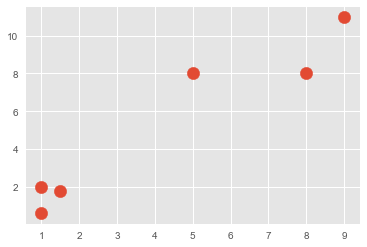

In [118]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np

X = np.array([[1, 2],
              [1.5, 1.8],
              [5, 8 ],
              [8, 8],
              [1, 0.6],
              [9,11]])

plt.scatter(X[:,0], X[:,1], s=150)
plt.show()

colors = 10*["g","r","c","b","k"]


class K_Means:
    def __init__(self, k=5, tol=0.001, max_iter=50):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            if optimized:
                break
    
    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

25.0


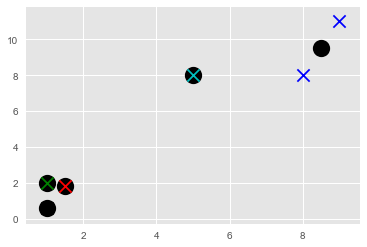

In [119]:
clf = K_Means()
clf.fit(X)

for centroid in clf.centroids:
    plt.scatter(clf.centroids[centroid][0], clf.centroids[centroid][1],
                marker="o", color="k", s=150, linewidths=5)

for classification in clf.classifications:
    color = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=150, linewidths=5)
        
plt.show()

In [ ]:
figures = []

for n_clusters in range(2, 13):
    # Create a subplot with 1 row and 2 columns
    fig = tools.make_subplots(rows=1, cols=2,
                              print_grid=False,
                              subplot_titles=('The silhouette plot for the various clusters.',
                                              'The visualization of the clustered data.'))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    fig['layout']['xaxis1'].update(title='The silhouette coefficient values',
                                   range=[-0.1, 1])
   
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    fig['layout']['yaxis1'].update(title='Cluster label',
                                   showticklabels=False,
                                   range=[0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        
        filled_area = go.Scatter(y=np.arange(y_lower, y_upper),
                                 x=ith_cluster_silhouette_values,
                                 mode='lines',
                                 showlegend=False,
                                 line=dict(width=0.5,
                                          color=colors),
                                 fill='tozerox')
        fig.append_trace(filled_area, 1, 1)
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        

    # The vertical line for average silhouette score of all the values
    axis_line = go.Scatter(x=[silhouette_avg],
                           y=[0, len(X) + (n_clusters + 1) * 10],
                           showlegend=False,
                           mode='lines',
                           line=dict(color="red", dash='dash',
                                     width =1) )

    fig.append_trace(axis_line, 1, 1)
    
    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.colors.colorConverter.to_rgb(cm.spectral(float(i) / n_clusters))
    colors = 'rgb'+str(colors)
    clusters = go.Scatter(x=X[:, 0], 
                          y=X[:, 1], 
                          showlegend=False,
                          mode='markers',
                          marker=dict(color=colors,
                                     size=4)
                         )
    fig.append_trace(clusters, 1, 2)
    
    # Labeling the clusters
    centers_ = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    centers = go.Scatter(x=centers_[:, 0], 
                         y=centers_[:, 1],
                         showlegend=False,
                         mode='markers',
                         marker=dict(color='green', size=10,
                                     line=dict(color='black',
                                                             width=1))
                        )

    fig.append_trace(centers, 1, 2)
    
    fig['layout']['xaxis2'].update(title='Feature space for the 1st feature',
                                   zeroline=False)
    fig['layout']['yaxis2'].update(title='Feature space for the 2nd feature',
                                  zeroline=False)
                              

    fig['layout'].update(title="Silhouette analysis for KMeans clustering on sample data "
                         "with n_clusters = %d" % n_clusters)
    
    figures.append(fig)

### 2.2 k-medoids

PAM
https://github.com/letiantian/kmedoids

## 3. Density-based Clustering

### 3.1 DBSCAN

https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

In this example, we are given the data:

<font color=green>[(0, 0), (1, 2), (1, 6), (2, 3), (3, 4), (5, 1), (4, 2), (5, 3), (6, 2), (7, 4)]</font>

The eps-neighborhood = $\sqrt{2}$ <br>
MinPts = 3


__(a) List the clusters in terms of their points__

* Cluster 1: {(2, 3), (1, 2), (3, 4)}
* Cluster 2: {(5, 1), (4, 2), (6, 2), (5, 3)}

In [63]:
data2 = [(0, 0), (1, 2), (1, 6), (2, 3), (3, 4), (5, 1), (4, 2), (5, 3), (6, 2), (7, 4)]

df2 = pd.DataFrame(data2, index=data2)
pd.DataFrame(distance_matrix(df2.values, df2.values), index=df2.index, columns=df2.index)

,"(0, 0)","(1, 2)","(1, 6)","(2, 3)","(3, 4)","(5, 1)","(4, 2)","(5, 3)","(6, 2)","(7, 4)"
"(0, 0)",0.000000,2.236068,6.082763,3.605551,5.000000,5.099020,4.472136,5.830952,6.324555,8.062258
"(1, 2)",2.236068,0.000000,4.000000,1.414214,2.828427,4.123106,3.000000,4.123106,5.000000,6.324555
"(1, 6)",6.082763,4.000000,0.000000,3.162278,2.828427,6.403124,5.000000,5.000000,6.403124,6.324555
"(2, 3)",3.605551,1.414214,3.162278,0.000000,1.414214,3.605551,2.236068,3.000000,4.123106,5.099020
"(3, 4)",5.000000,2.828427,2.828427,1.414214,0.000000,3.605551,2.236068,2.236068,3.605551,4.000000
"(5, 1)",5.099020,4.123106,6.403124,3.605551,3.605551,0.000000,1.414214,2.000000,1.414214,3.605551
"(4, 2)",4.472136,3.000000,5.000000,2.236068,2.236068,1.414214,0.000000,1.414214,2.000000,3.605551
"(5, 3)",5.830952,4.123106,5.000000,3.000000,2.236068,2.000000,1.414214,0.000000,1.414214,2.236068
"(6, 2)",6.324555,5.000000,6.403124,4.123106,3.605551,1.414214,2.000000,1.414214,0.000000,2.236068
"(7, 4)",8.062258,6.324555,6.324555,5.099020,4.000000,3.605551,3.605551,2.236068,2.236068,0.000000


In [67]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics

X = np.array(data2)
a = np.sqrt(2)

db = DBSCAN(eps=a, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
db

DBSCAN(algorithm='auto', eps=1.4142135623730951, leaf_size=30,
    metric='euclidean', metric_params=None, min_samples=3, n_jobs=None,
    p=None)

In [68]:
# Number of clusters in labels, ignoring noise if present.

labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

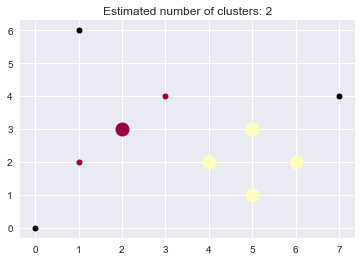

In [69]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

__(b) What are the density-connected points?__

-  (3, 4), (2, 3) and (1, 2) are density- connected, since (3, 4), (1, 2) and both density-reachable from (2, 3) <br>

-  (5, 1), (5, 3), (4, 2), (6, 2) are density- connected, since (5, 1) and (5, 3) are both density-reachable from (4, 2) and (6, 2)

__(c) What points (if any) does DBSCAN consider as noise?__

-  (0, 0), (1, 6), (7, 4) are considered noise.